In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
import sklearn.metrics as metrics
from time import time

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


## Datenbank einbinden
* Temperatursensor 1

In [2]:
connection = sql.connect("gcs_gh_10012022.db")
query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

In [3]:
df_temp1 = df_temp1.sort_index().loc['2021-08-20':'2021-08-31']

## Ausreißer behandeln
https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
https://github.com/kdrelczuk/medium/blob/master/anomalies_local.py#L37

In [4]:
column = df_temp1['value']

k = int(len(column) * (0.16/100))
N = len(column)
print("Window size: ", k)
print("Datapoints: ", N)

time = np.arange(0,N)
column = column.to_numpy()

get_bands = lambda df_temp1 : (np.mean(df_temp1) + 3*np.std(df_temp1), np.mean(df_temp1) - 3*np.std(df_temp1))

Window size:  5
Datapoints:  3277


In [5]:
bands = [get_bands(column[range(0 if i - k < 0 else i-k ,i + k if i + k < N else N)]) for i in range(0,N)]
upper, lower = zip(*bands)

In [6]:
anomalies = (df_temp1['value'] > upper) | (df_temp1['value'] < lower)

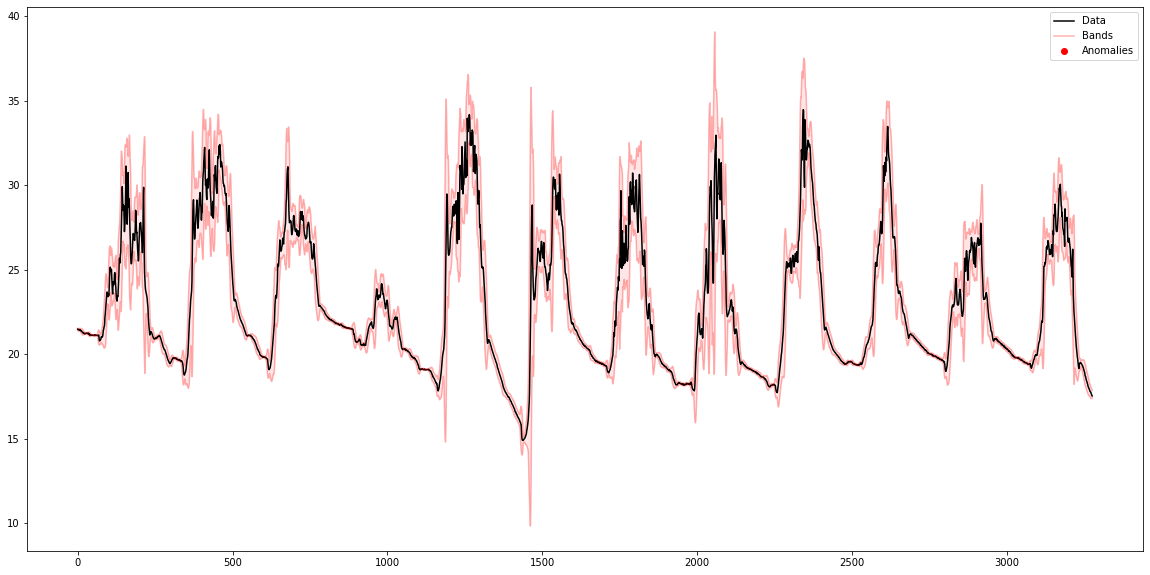

In [7]:
plt.figure(figsize=(20,10))
plt.plot(time,column,'k',label='Data')
plt.plot(time,upper,'r-',label='Bands',alpha=0.3)
plt.plot(time,lower,'r-',alpha=0.3)

plt.plot(time[anomalies],column[anomalies],'ro',label='Anomalies')
plt.fill_between(time, upper, lower,facecolor='red',alpha=0.1)
plt.legend()

In [8]:
anomalies = anomalies.index[anomalies]
print(anomalies)

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)


In [9]:
df_temp1['value'].sort_index().loc[anomalies].replace(np.NaN, inplace=True)
print(df_temp1['value'].isna().any())

False


## Datenlücken, duplizierte Indices behandeln

In [10]:
# prüfen ob doppelte Index-Werte (Timestamp) vorhanden 
print('TS has duplicates:', df_temp1.index.has_duplicates)
print('TS has NaN:', df_temp1['value'].isna().any())

# dopplte Index-Werte der Ausgangszeitreihe anzeigen 
df_temp1_duplicates = df_temp1[df_temp1.index.duplicated()]
print(df_temp1_duplicates)
print()

# Zeitreihe nach Behandlung der Indizes und Lücken durch Zusammenfassen anzeigen
df_temp1_5min = df_temp1.resample('5Min').mean()
print('TS 5min Intervals has duplicates:', df_temp1_5min.index.has_duplicates)
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

## Zeiträume sehen, in denen keine Daten vorhanden sind und durch das Zusammenfassen zu NaN werden
# print(df_temp1_5min.head(60))
# print(df_temp1.head(60))

TS has duplicates: True
TS has NaN: False
                        value
timestamp                    
2021-08-24 03:06:16  19.06386
2021-08-24 03:06:16  19.07721
2021-08-24 03:06:16  19.09057
2021-08-24 03:06:16  19.07721

TS 5min Intervals has duplicates: False
TS 5min Intervals has NaN: True


In [11]:
df_temp1_5min = df_temp1_5min.fillna(method='ffill')
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

TS 5min Intervals has NaN: False


## Daten zusammenfassen

In [12]:
df_temp1_hourly = df_temp1_5min.resample('H').mean()

## Stationarität

### Prüfen der Stationarität

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

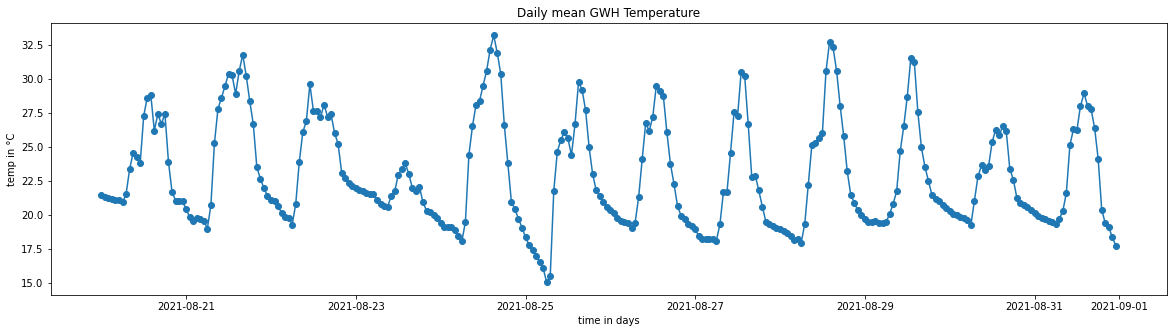

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

In [14]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.308020630393367
p-value: 3.8562431296871696e-13
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174


Da (p-Wert) 4.64x10^-14 < (p-Wert Schwelle) 0.05 , wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. <br>

In [51]:
df_temp1_hourly = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))
decomp_result = seasonal_decompose(df_temp1_hourly['value'], model='additive')

trend = decomp_result.trend
periodic = decomp_result.seasonal
residual = decomp_result.resid

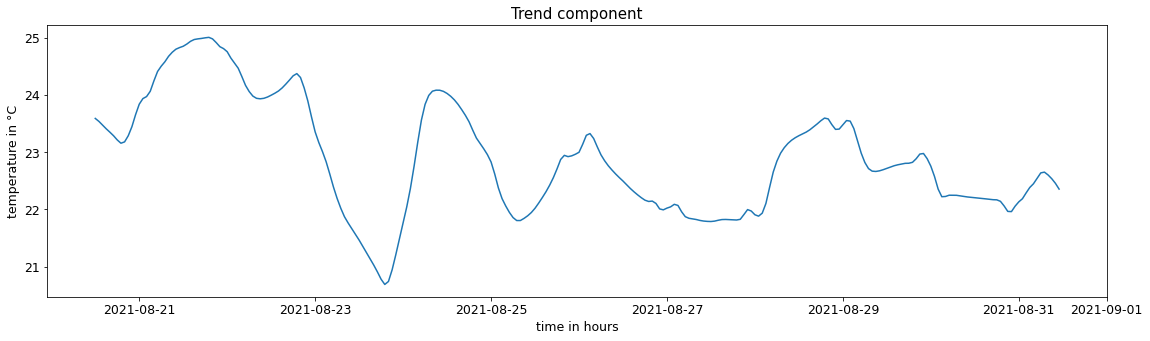

In [62]:
plt.figure(figsize=(19,5))
plt.title('Trend component')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 

plt.plot(trend)

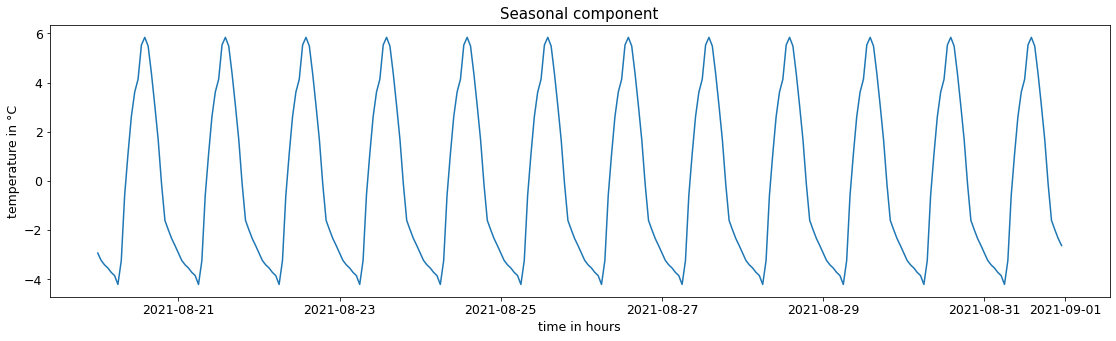

In [63]:
plt.figure(figsize=(19,5))
plt.title('Seasonal component')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 

plt.plot(periodic)

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

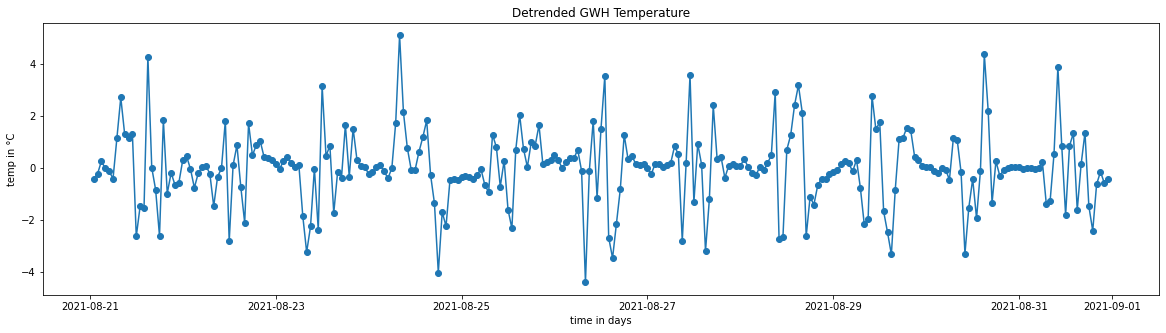

In [15]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff - series_temp1_stationary_diff.shift(1)
df_temp1_stationary = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_stationary.columns.values[0] = "value"

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.scatter(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [16]:
df_temp1_stationary = df_temp1_stationary.fillna(method='ffill').dropna()

series = df_temp1_stationary
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.155314768767172
p-value: 7.392879436913489e-08
Critial Values:
   1%, -3.457215237265747
Critial Values:
   5%, -2.873361841566324
Critial Values:
   10%, -2.5730700760129555


## Autokorrelation

### ACF

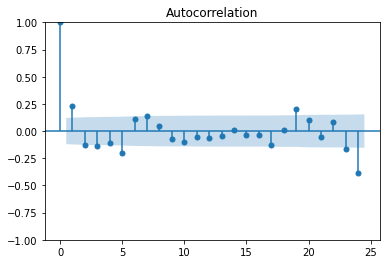

In [17]:
acf_result = stattools.acf(df_temp1_stationary)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_temp1_stationary, lags=24)

### PACF

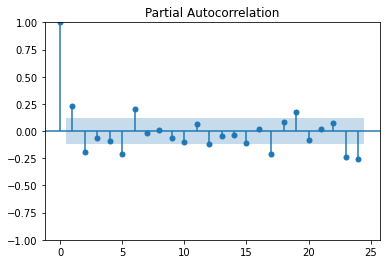

In [18]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_temp1_stationary,  method='ywm', lags=24)

## Daten splitten

In [19]:
# Frequenz der Zeitreihe wird festgelegt
df_temp1_modelling_data = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))

In [20]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_data = df_temp1_modelling_data.sort_index().loc['2021-08-20':'2021-08-28']
test_data = df_temp1_modelling_data.sort_index().loc['2021-08-29':'2021-08-31']

In [21]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

## AR(I)MA-Modell

### ARIMA(2,0,3)
* selbst geschätzt anhand ACF, PACF

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean absolute error (MAE):  2.8494429921790867
Mean squared error (MSE):  10.216321177656734
Root Mean sqaured error (RMSE):  3.196298042682618


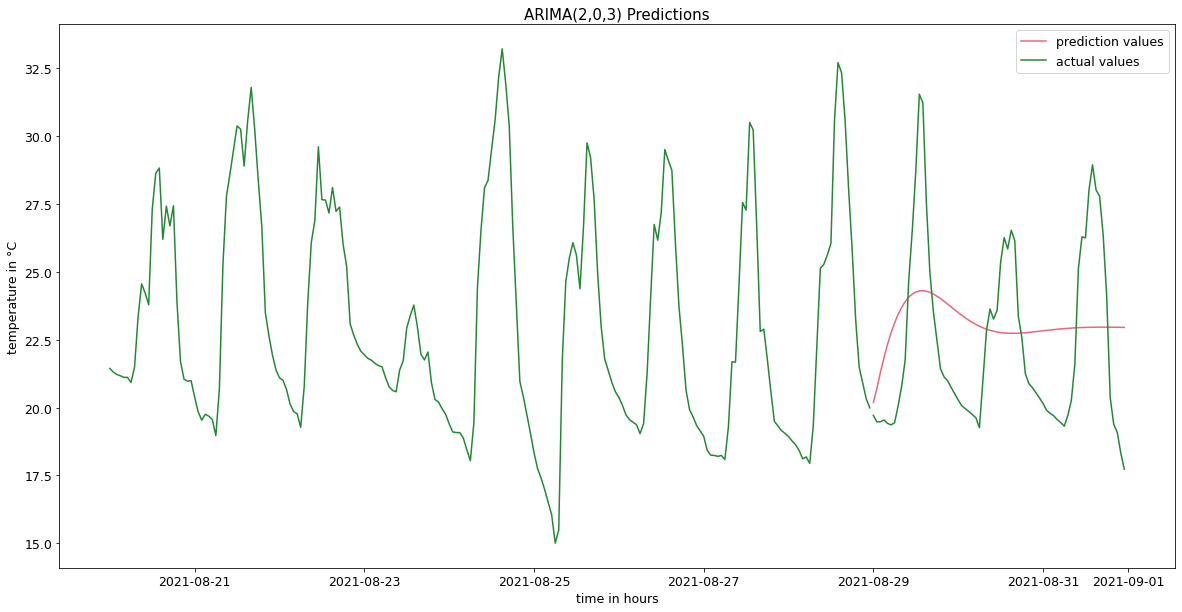

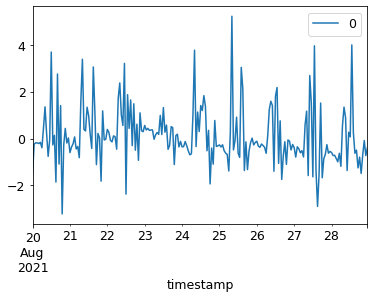

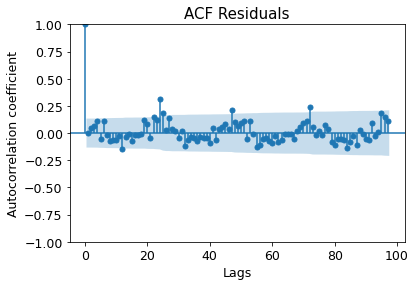

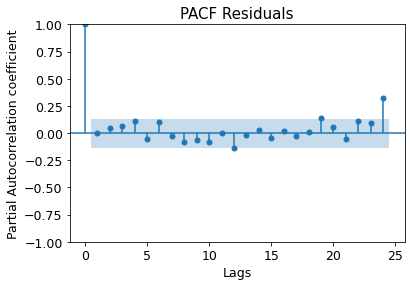

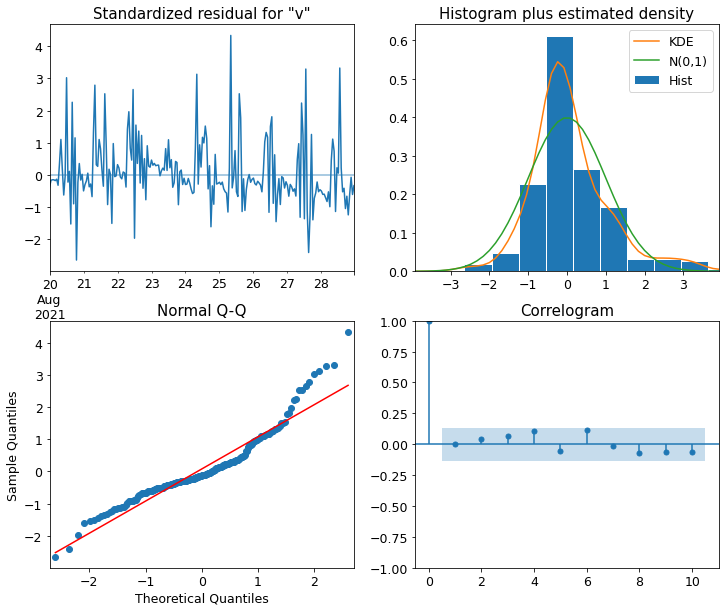

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  216
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -348.639
Date:                Mon, 04 Jul 2022   AIC                            711.278
Time:                        08:42:18   BIC                            734.905
Sample:                    08-20-2021   HQIC                           720.824
                         - 08-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.9345      0.207    110.976      0.000      22.529      23.340
ar.L1          1.8400      0.039     47.321      0.000       1.764       1.916
ar.L2         -0.8593      0.041    -21.096      0.000      -0.939      -0.779
ma.L1         -0.4406      0.173     -2.545      0.011      -0.780      -0.101
ma.L2         -0.3203      0.117     -2.742      0.006      -0.549      -0.091
ma.L3         -0.2370      0.079     -3.014      0.003      -0.391      -0.083
sigma2         1.4422      0.251      5.755      0.000       0.951       1.933
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               100.88
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             1.10
Prob(H) (two-sided):                  0.90   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
model = ARIMA(train_data, order=(2,0,3))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
df_temp1['forecast'] = fcast
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='ARIMA(2,0,3) Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],
#                 ts_ci.iloc[1:, 1], color='k', alpha=.2, label='prediction interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient")

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

## Gridsearch

In [23]:
p = range(0,3)
d = range(1)
q = range(0,4)
pdq = list(itertools.product(p,d,q)) # alle Kombis von p,d,q
combs = {}
aics = []

In [24]:
for combination in pdq:
    model = ARIMA(train_data, order=combination,
                  enforce_stationarity=True,
                  enforce_invertibility=True)
    model = model.fit()
    combs.update({model.aic : [combination]})
    aics.append(model.aic)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

In [25]:
best_aic = min(aics)
print('best aic is: ', round(best_aic, 3))
print(14*'==')
print ('ARIMA parameters: ',combs[best_aic][0])

best aic is:  693.848
ARIMA parameters:  (2, 0, 2)


Mean absolute error (MAE):  2.397371367588348
Mean squared error (MSE):  7.9313176597180455
Root Mean sqaured error (RMSE):  2.8162595156906343


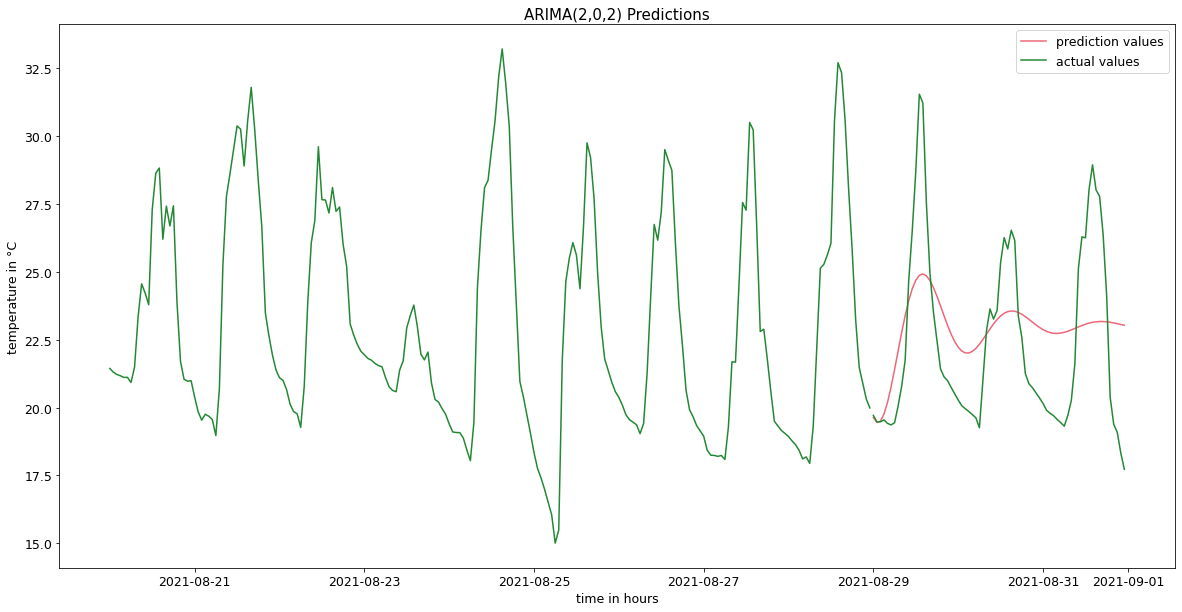

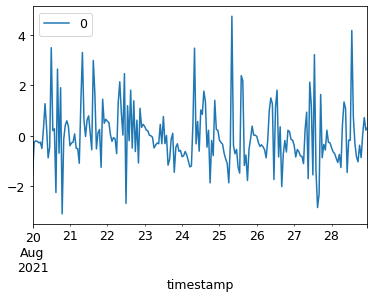

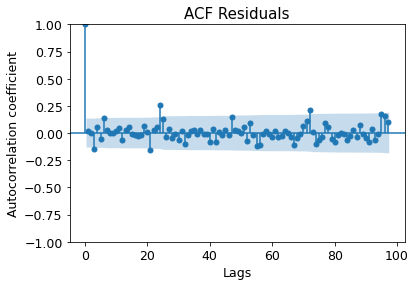

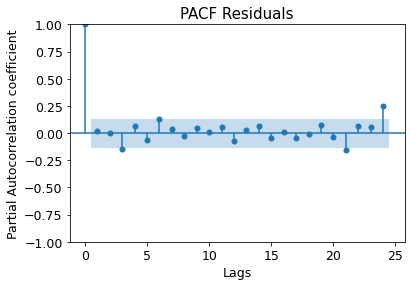

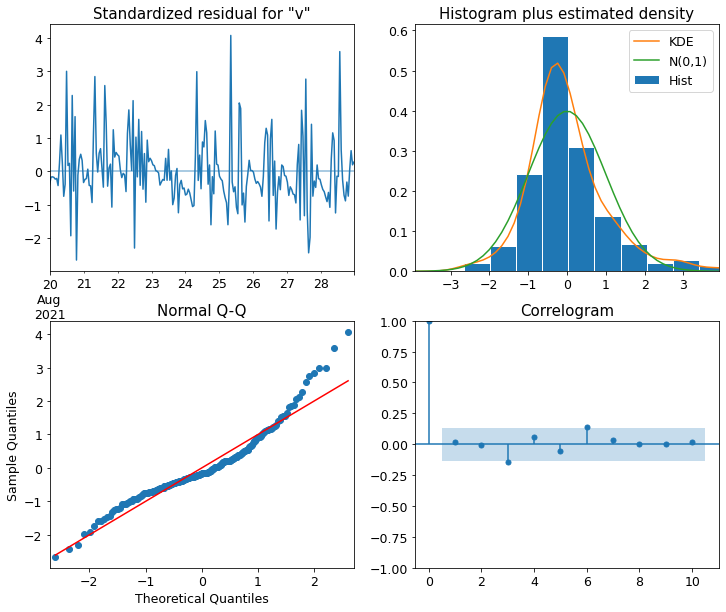

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  216
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -340.924
Date:                Mon, 04 Jul 2022   AIC                            693.848
Time:                        08:41:34   BIC                            714.100
Sample:                    08-20-2021   HQIC                           702.030
                         - 08-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0192      0.372     61.798      0.000      22.289      23.749
ar.L1          1.8441      0.040     46.147      0.000       1.766       1.922
ar.L2         -0.9050      0.038    -23.897      0.000      -0.979      -0.831
ma.L1         -0.5405      0.067     -8.058      0.000      -0.672      -0.409
ma.L2         -0.2442      0.072     -3.412      0.001      -0.385      -0.104
sigma2         1.3552      0.117     11.609      0.000       1.126       1.584
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                77.97
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.96
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
# Modell anpassen
model = ARIMA(train_data, order=(2,0,2))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
df_temp1['forecast'] = model_fit.predict(start=pred_start, end=pred_end)
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='ARIMA(2,0,2) Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],plt.title(label='ARIMA(2,0,2) Predictions')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient") 

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

## auto_arima


In [28]:
stepwise_fit = auto_arima(train_data,
                            test='adf',
                            m = 1,
                            d = None,
                            seasonal=False,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -340.924
Date:                Sun, 03 Jul 2022   AIC                            693.848
Time:                        23:13:02   BIC                            714.100
Sample:                             0   HQIC                           702.030
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4026      0.247      5.676      0.000       0.918       1.887
ar.L1          1.8441      0.040     46.170      0.000       1.766       1.922
ar.L2         -0.9051      0.038    -23.907      0.000      -0.979      -0.831
ma.L1         -0.5406      0.067     -8.063      0.000      -0.672      -0.409
ma.L2         -0.2443      0.072     -3.415      0.001      -0.385      -0.104
sigma2         1.3549      0.117     11.613      0.000       1.126       1.584
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                77.99
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.96
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
connection.close()